In [194]:
import IO_map
import random
import re
import generate_verilog as gv
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
import re

"""
Wire can be in many groups: A wire can be on many linear paths
    - Every wire is initally in a group with it's parent and child modules
Wire can be in many loops: A wire can be on many looped paths
Groups contains {group_id : [modules in that group]}
    - Initially one group for every input and output pair 
    - Group id is initially the wire id, since each wire is in it's own group
Loops contains {loop_id : [modules in that loop]}

"""
class Fuzz_Run:
    def __init__(self, flattened_lib_path):
        random.seed(1)
        self.flattened_lib_path = flattened_lib_path
        io_map = IO_map.create_IO_map(flattened_lib_path)

        self.all_wires = io_map['bit_input'].copy()
        self.all_wires.update(io_map['bit_output']) # Single source of truth
        
        self.mod_IO = io_map['mod_IO']
        self.all_modules = io_map['mod_list']

        self.external_inputs = list(io_map['bit_input'].keys())
        self.external_outputs = list(io_map['bit_output'].keys()) # Unchanged will always output all outputs

        self.module_tree = {}
        for i in range(len(io_map['mod_list'])):
            module = io_map['mod_list'][i]
            self.module_tree[module] = {"depth" : 0, "tree":i, "children" : [], "parents":[], "loops":[]}

        self.loops = {}
        self.loop_set = set()
        
    def visualize_graph(self):
        G = nx.DiGraph()
        G.add_node("EXT_INPUT", color="green")
        G.add_node("EXT_OUTPUT", color="red")

        for mod in self.all_modules:
            G.add_node(mod, color="lightblue")

        edge_labels = {}
        edge_styles = {}

        for wire in self.all_wires.values():
            if wire.type == IO_map.Wire.Wire_Type.ITM:
                dst_port = wire.output[0] if wire.output else None
                if dst_port and "_input_" in dst_port:
                    dst_mod = dst_port.split("_input_")[0]
                    G.add_edge("EXT_INPUT", dst_mod)
                    edge_labels[("EXT_INPUT", dst_mod)] = f"w{wire.id}"
                    edge_styles[("EXT_INPUT", dst_mod)] = ("gray", "solid")

            elif wire.type == IO_map.Wire.Wire_Type.MTM:
                src_mod = wire.input
                if "_output_" not in src_mod:
                    src_mod = src_mod.split("_output_")[0]
                for dst in wire.output:
                    if dst == "output":
                        G.add_edge(src_mod, "EXT_OUTPUT")
                        edge_labels[(src_mod, "EXT_OUTPUT")] = f"w{wire.id}"
                        edge_styles[(src_mod, "EXT_OUTPUT")] = ("gray", "solid")
                    elif "_input_" in dst:
                        dst_mod = dst.split("_input_")[0]
                        G.add_edge(src_mod, dst_mod)
                        label = f"w{wire.id}"
                        edge_labels[(src_mod, dst_mod)] = label

                        # Style based on reg/cycle
                        if wire.reg:
                            edge_styles[(src_mod, dst_mod)] = ("red", "solid")
                        elif (self.module_tree[src_mod]["loops"]
                            or self.module_tree[dst_mod]["loops"]):
                            edge_styles[(src_mod, dst_mod)] = ("blue", "dashed")
                        else:
                            edge_styles[(src_mod, dst_mod)] = ("gray", "solid")

        pos = nx.spring_layout(G, seed=42)
        node_colors = [G.nodes[n].get("color", "white") for n in G.nodes()]
        nx.draw(G, pos, with_labels=True, node_color=node_colors,
                node_size=1000, font_size=8)

        # Draw edges with different colors & styles
        for (u, v), (color, style) in edge_styles.items():
            nx.draw_networkx_edges(G, pos, edgelist=[(u, v)],
                                edge_color=color,
                                style=style,
                                width=2 if color != "gray" else 1)

        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6)
        plt.title("Module Graph (Red=Reg, Blue=Cycle, Gray=Normal)")
        plt.show()

 
    def visualize_graph_no_ext_out(self):
        """
        Visualize the module graph without external outputs.
        - Red solid edges: wires with reg=True (registered).
        - Blue dashed edges: cycle edges (modules in self.loops).
        - Gray solid edges: normal wires.
        """
        G = nx.DiGraph()
        G.add_node("EXT_INPUT", color="green")

        for mod in self.all_modules:
            G.add_node(mod, color="lightblue")

        edge_labels = {}
        edge_styles = {}

        for wire in self.all_wires.values():
            if wire.type == IO_map.Wire.Wire_Type.ITM:
                dst_port = wire.output[0] if wire.output else None
                if dst_port and "_input_" in dst_port:
                    dst_mod = dst_port.split("_input_")[0]
                    G.add_edge("EXT_INPUT", dst_mod)
                    edge_labels[("EXT_INPUT", dst_mod)] = f"w{wire.id}"
                    edge_styles[("EXT_INPUT", dst_mod)] = ("gray", "solid")

            elif wire.type == IO_map.Wire.Wire_Type.MTM:
                src_mod = wire.input
                if "_output_" in src_mod:
                    src_mod = src_mod.split("_output_")[0]

                for dst in wire.output:
                    if dst == "output":
                        continue  # No external outputs in this view
                    if "_input_" in dst:
                        dst_mod = dst.split("_input_")[0]
                        G.add_edge(src_mod, dst_mod)
                        edge_labels[(src_mod, dst_mod)] = f"w{wire.id}"

                        # Style based on reg/cycle
                        if wire.reg:
                            edge_styles[(src_mod, dst_mod)] = ("red", "solid")
                        elif (self.module_tree[src_mod]["loops"]):
                            edge_styles[(src_mod, dst_mod)] = ("blue", "dashed")
                        else:
                            edge_styles[(src_mod, dst_mod)] = ("gray", "solid")

        pos = nx.spring_layout(G, seed=42)
        node_colors = [G.nodes[n].get("color", "white") for n in G.nodes()]
        nx.draw(G, pos, with_labels=True, node_color=node_colors,
                node_size=1000, font_size=8)

        # Draw edges with appropriate styles
        for (u, v), (color, style) in edge_styles.items():
            nx.draw_networkx_edges(G, pos, edgelist=[(u, v)],
                                edge_color=color,
                                style=style,
                                width=2 if color != "gray" else 1)

        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6)
        plt.title("Module Graph (No EXT Output) [Red=Reg, Blue=Cycle, Gray=Normal]")
        plt.show()

    def _mod_from_port(self, port_str):
        """Helper function to extract module name from a port string like 'adder_wrapper_input_3'."""
        if "_input_" in port_str:
            return port_str.split("_input_")[0]
        elif "_output_" in port_str:
            return port_str.split("_output_")[0]
        raise ValueError(f"Unrecognized port name format: {port_str}")
    
    def shift_module_depth_below(self, A: str, B: str, merge_trees: bool = False):
        """
        Shift the subtree rooted at module B so that B is at depth A.depth + 1.
        Always updates parent/child relationship: A → B.

        If merge_trees is False:
            - Requires A and B in the same tree.
            - Requires A.depth <= B.depth.
            - Shift happens only if A.depth == B.depth.
            - Only B and its descendants are shifted (not its parents).

        If merge_trees is True:
            - B and its entire subtree are shifted to A.depth + 1.
            - Tree ID of B, its descendants, and its parents are changed to A's tree.
        """
        if A not in self.module_tree or B not in self.module_tree:
            print(f"[Shift] One or both modules '{A}' and '{B}' do not exist.")
            return

        depth_A = self.module_tree[A]["depth"]
        depth_B = self.module_tree[B]["depth"]
        tree_A = self.module_tree[A]["tree"]
        tree_B = self.module_tree[B]["tree"]

        if not merge_trees:
            assert tree_A == tree_B, f"[Shift] Can't shift: '{A}' and '{B}' are in different trees."
            assert depth_A <= depth_B, f"[Shift] Can't shift: '{A}' is deeper than '{B}' in same tree."

            if depth_A != depth_B:
                print(f"[Shift] Skipped depth shift: '{A}' and '{B}' are not at the same depth.")
            else:
                # Shift B and descendants by +1
                queue = [B]
                visited = set()

                while queue:
                    current = queue.pop(0)
                    if current in visited:
                        continue
                    visited.add(current)

                    self.module_tree[current]["depth"] += 1

                    for child in self.module_tree[current]["children"]:
                        if child not in visited:
                            queue.append(child)

        else:
            # Calculate how much we need to shift B to be just below A
            delta = (depth_A + 1) - depth_B

            # Shift B and its descendants
            queue = [B]
            visited = set()

            while queue:
                current = queue.pop(0)
                if current in visited:
                    continue
                visited.add(current)

                self.module_tree[current]["depth"] += delta
                self.module_tree[current]["tree"] = tree_A

                for child in self.module_tree[current]["children"]:
                    if child not in visited:
                        queue.append(child)

            # Update all parents of B to tree_A
            parent_queue = list(self.module_tree[B]["parents"])
            seen_parents = set()

            while parent_queue:
                parent = parent_queue.pop()
                if parent in seen_parents:
                    continue
                seen_parents.add(parent)
                self.module_tree[parent]["tree"] = tree_A
                parent_queue.extend(self.module_tree[parent]["parents"])

        # Always update parent/child relationship
        if B not in self.module_tree[A]["children"]:
            self.module_tree[A]["children"].append(B)
        if A not in self.module_tree[B]["parents"]:
            self.module_tree[B]["parents"].append(A)

        print(f"[Shift] Parent/child set: '{A}' → '{B}'. Tree merged: {merge_trees}")

    def linear_rewire(self):
        """
        Rewire one external output (MTO/MTM) to an internal input (ITM).
        Ensures mod_IO and all_wires stay consistent after rewiring.
        Updates wire type:
        - MTO → MTM if adding a module connection
        - MTM → MTO if only 'output' remains after removing a connection
        Rules:
        - Never rewire registered wires (reg=True).
        - Never rewire if:
            * One module is parent/child of the other (directly).
            * Both modules are already in loops.
            * Rewiring would reverse an existing parent-child hierarchy
                (e.g., making a parent become a child, which increases depth indefinitely).
        """
        if not self.external_outputs:
            print("[Rewire] No external outputs to rewire.")
            return

        for _ in range(len(self.external_outputs)):
            output_wire_id = self.external_outputs[random.randrange(len(self.external_outputs))]
            output_wire = self.all_wires[output_wire_id]
            assert output_wire.type in (IO_map.Wire.Wire_Type.MTM, IO_map.Wire.Wire_Type.MTO)

            output_port = output_wire.input
            assert "_output_" in output_port

            output_mod = output_port.split("_output_")[0]

            # Skip if this wire is registered and belongs to a loop
            if output_wire.reg and output_mod in self.loop_set:
                continue

            output_tree = self.module_tree[output_mod]["tree"]
            output_depth = self.module_tree[output_mod]["depth"]

            for _ in range(len(self.all_modules)):
                target_mod = self.all_modules[random.randrange(len(self.all_modules))]
                if target_mod == output_mod:
                    continue

                target_tree = self.module_tree[target_mod]["tree"]
                target_depth = self.module_tree[target_mod]["depth"]

                # --- New Checks ---
                # 1. Skip if both modules are already in loops
                if output_mod in self.loop_set and target_mod in self.loop_set:
                    continue

                # 2. Skip if direct parent-child already exists
                if target_mod in self.module_tree[output_mod]["parents"] or \
                target_mod in self.module_tree[output_mod]["children"] or \
                output_mod in self.module_tree[target_mod]["parents"] or \
                output_mod in self.module_tree[target_mod]["children"]:
                    continue

                # 3. Skip if this rewiring would reverse hierarchy (make parent become child)
                # If target is an ancestor of output_mod, rewiring would make parent into child
                def is_ancestor(ancestor, descendant):
                    visited, stack = set(), [ancestor]
                    while stack:
                        cur = stack.pop()
                        if cur == descendant:
                            return True
                        for p in self.module_tree[cur]["parents"]:
                            if p not in visited:
                                visited.add(p)
                                stack.append(p)
                    return False

                if is_ancestor(target_mod, output_mod):
                    continue

                # Skip if would create illegal cycle by depth rule
                if target_tree == output_tree and target_depth < output_depth:
                    continue

                target_inputs = list(self.mod_IO[target_mod]['inputs'])
                if not target_inputs:
                    continue

                target_wire_id = target_inputs[random.randrange(len(target_inputs))]
                target_wire = self.all_wires[target_wire_id]

                # Skip if target wire is registered and looped
                if target_wire.reg and target_mod in self.loop_set:
                    continue

                ports = [p for p in target_wire.output if p.startswith(target_mod)]
                if not ports:
                    continue
                target_port = ports[0]

                # ===============================
                # CONSISTENT REWIRING UPDATES
                # ===============================
                output_wire.output.append(target_port)

                # Update type if previously MTO (now drives a module too)
                if output_wire.type == IO_map.Wire.Wire_Type.MTO:
                    output_wire.type = IO_map.Wire.Wire_Type.MTM

                if output_wire.id not in self.mod_IO[target_mod]['inputs']:
                    self.mod_IO[target_mod]['inputs'].add(output_wire.id)

                # Disconnect target wire only if not registered
                if not (target_wire.reg and target_mod in self.loop_set):
                    if target_port in target_wire.output:
                        target_wire.output.remove(target_port)

                    still_drives_module = any(p.startswith(f"{target_mod}_input_") for p in target_wire.output)
                    if not still_drives_module and target_wire_id in self.mod_IO[target_mod]['inputs']:
                        self.mod_IO[target_mod]['inputs'].remove(target_wire_id)

                    # Update type if now only drives 'output'
                    if target_wire.type == IO_map.Wire.Wire_Type.MTM and target_wire.output == ['output']:
                        target_wire.type = IO_map.Wire.Wire_Type.MTO

                    # Remove ITM wire if fully disconnected
                    if target_wire.type == IO_map.Wire.Wire_Type.ITM and not target_wire.output:
                        if target_wire.id in self.all_wires:
                            self.all_wires.pop(target_wire.id)
                        if target_wire.id in self.external_inputs:
                            self.external_inputs.remove(target_wire.id)

                merge_trees = target_tree != output_tree
                self.shift_module_depth_below(output_mod, target_mod, merge_trees)

                assert output_wire.id in self.mod_IO[target_mod]['inputs'], \
                    f"[Rewire-Error] {output_wire.id} missing from {target_mod} inputs after rewiring"

                print(f"[Rewire] {output_mod} → {target_mod} via {target_port}")
                return

        print("[Rewire] No valid rewiring opportunity found.")



    def cyclical_rewire(self):
        """
        Rewire exactly ONE wire to create a cycle (back-edge).
        - Updates all modules in the cycle within module_tree.
        - Never removes or alters registered wires (reg=True).
        - MTO ↔ MTM transitions handled consistently.
        """
        if not self.external_outputs:
            print("[Cyclical-Rewire] No external outputs to rewire.")
            return

        for _ in range(len(self.external_outputs)):
            output_wire_id = self.external_outputs[random.randrange(len(self.external_outputs))]
            output_wire = self.all_wires[output_wire_id]
            assert output_wire.type in (IO_map.Wire.Wire_Type.MTM, IO_map.Wire.Wire_Type.MTO)

            output_port = output_wire.input
            assert "_output_" in output_port

            output_mod = output_port.split("_output_")[0]

            # Skip if this output_wire is already registered and looped (never modify existing registered wires)
            if output_wire.reg and output_mod in self.loop_set:
                continue

            output_tree = self.module_tree[output_mod]["tree"]
            output_depth = self.module_tree[output_mod]["depth"]

            for _ in range(len(self.all_modules)):
                target_mod = self.all_modules[random.randrange(len(self.all_modules))]
                if target_mod == output_mod:
                    continue

                target_tree = self.module_tree[target_mod]["tree"]
                target_depth = self.module_tree[target_mod]["depth"]

                # Skip if would create illegal loop
                if target_tree != output_tree or target_depth >= output_depth:
                    continue

                target_inputs = list(self.mod_IO[target_mod]['inputs'])
                if not target_inputs:
                    continue

                target_wire_id = target_inputs[random.randrange(len(target_inputs))]
                target_wire = self.all_wires[target_wire_id]

                # Never modify existing registered wires in loops
                if target_wire.reg and target_mod in self.loop_set:
                    continue

                ports = [p for p in target_wire.output if p.startswith(target_mod)]
                if not ports:
                    continue
                target_port = ports[0]

                try:
                    cycle = self._construct_cycle(target_mod, output_mod)
                except RuntimeError:
                    continue

                # Skip if any module in cycle already looped
                if any(m in self.loop_set for m in cycle):
                    continue

                # ===============================
                # CONSISTENT REWIRING UPDATES
                # ===============================
                output_wire.output.append(target_port)
                output_wire.reg = True  # The source module’s outputs must all be registered now

                # Update type if previously MTO (now drives a module too)
                if output_wire.type == IO_map.Wire.Wire_Type.MTO:
                    output_wire.type = IO_map.Wire.Wire_Type.MTM

                if output_wire.id not in self.mod_IO[target_mod]['inputs']:
                    self.mod_IO[target_mod]['inputs'].add(output_wire.id)

                # Disconnect old wire only if not registered
                if not (target_wire.reg and target_mod in self.loop_set):
                    if target_port in target_wire.output:
                        target_wire.output.remove(target_port)

                    still_drives_module = any(p.startswith(f"{target_mod}_input_") for p in target_wire.output)
                    if not still_drives_module and target_wire_id in self.mod_IO[target_mod]['inputs']:
                        self.mod_IO[target_mod]['inputs'].remove(target_wire_id)

                    # Update type if now only drives 'output'
                    if target_wire.type == IO_map.Wire.Wire_Type.MTM and target_wire.output == ['output']:
                        target_wire.type = IO_map.Wire.Wire_Type.MTO

                    # Remove ITM wire if fully disconnected
                    if target_wire.type == IO_map.Wire.Wire_Type.ITM and not target_wire.output:
                        if target_wire.id in self.all_wires:
                            self.all_wires.pop(target_wire.id)
                        if target_wire.id in self.external_inputs:
                            self.external_inputs.remove(target_wire.id)

                if output_mod not in self.module_tree[target_mod]["parents"]:
                    self.module_tree[target_mod]["parents"].append(output_mod)
                if target_mod not in self.module_tree[output_mod]["children"]:
                    self.module_tree[output_mod]["children"].append(target_mod)

                # ===============================
                # LOOP REGISTRATION UPDATES
                # ===============================
                loop_id = f"loop_{len(self.loops)}"
                self.loops[loop_id] = cycle

                # Update ALL modules in the cycle
                for m in cycle:
                    self.module_tree[m]["loops"] = [loop_id]
                self.loop_set.update(cycle)

                # Mark ALL outputs of the source module as registered
                for w in self.all_wires.values():
                    if w.type in (IO_map.Wire.Wire_Type.MTM, IO_map.Wire.Wire_Type.MTO) and w.input.startswith(output_mod):
                        w.reg = True

                assert output_wire.id in self.mod_IO[target_mod]['inputs'], \
                    f"[Cyclical-Rewire-Error] {output_wire.id} missing from {target_mod} inputs after rewiring"

                print(f"[Cyclical-Rewire] {output_mod} → {target_mod} | Cycle: {cycle} | "
                    f"All outputs of {output_mod} marked reg=True")
                return

        print("[Cyclical-Rewire] No valid cyclical rewiring opportunity found.")


    def _construct_cycle(self, parent_mod, child_mod):
        """
        Finds the existing forward DAG path from parent_mod → ... → child_mod,
        ignoring modules already in loops.
        Returns a list of modules in cycle order: [parent_mod, ..., child_mod, parent_mod].
        """
        path = []
        found = False

        def dfs(current, target, visited):
            nonlocal found
            if found:
                return
            visited.append(current)

            if current == target:
                path.extend(visited)
                found = True
                return

            for child in self.module_tree[current]["children"]:
                if child in visited or child in self.loop_set:
                    continue
                dfs(child, target, visited.copy())

        dfs(parent_mod, child_mod, [])
        if not found:
            raise RuntimeError(f"[Cycle-Error] No valid DAG path from {parent_mod} to {child_mod}")

        path.append(parent_mod)
        return path

    def generate_top_module(self, top_name="top", output_path=""):
        """
        Generate a top-level Verilog module connecting all module_wrappers.
        Explicitly separates MTM and MTO wires:
        - MTM: drives modules and may also drive 'output'.
        - MTO: only drives 'output'.
        Handles reg=True (looped modules) and skips stale wires.
        """

        ext_inputs = self.external_inputs
        ext_outputs = self.external_outputs
        wire_map = self.all_wires
        mod_IO = self.mod_IO

        ext_in_pos = {wid: i for i, wid in enumerate(ext_inputs)}
        ext_out_pos = {wid: j for j, wid in enumerate(ext_outputs)}

        # Proper input/output ordering based on port names
        mod_in_order = {}
        for mod, io in mod_IO.items():
            def port_index(wid):
                ports = [p for p in self.all_wires[wid].output if p.startswith(mod)]
                return int(ports[0].split("_input_")[1]) if ports else 9999
            mod_in_order[mod] = sorted(io['inputs'], key=port_index)

        mod_out_order = {}
        for mod, io in mod_IO.items():
            def port_index_out(wid):
                return int(self.all_wires[wid].input.split("_output_")[1])
            mod_out_order[mod] = sorted(io['outputs'], key=port_index_out)

        mod_in_width = {mod: len(bits) for mod, bits in mod_in_order.items()}
        mod_out_width = {mod: len(bits) for mod, bits in mod_out_order.items()}

        lines = []
        lines.append("// Auto-generated Top Module for flattened IO")

        # Include wrapper files
        for mod in sorted(self.all_modules):
            lines.append(f"`include \"{mod}.sv\"")
        lines.append("")

        # Top module declaration
        lines.append(f"module {top_name} (")
        if ext_inputs:
            lines.append("    input  wire clk,")
            lines.append(f"    input  wire [{len(ext_inputs)-1}:0] in_flat,")
        else:
            lines.append("    input wire clk,  // no external inputs")
        if ext_outputs:
            lines.append(f"    output wire [{len(ext_outputs)-1}:0] out_flat")
        else:
            lines.append("    // no external outputs")
        lines.append(");\n")

        # Per-module I/O buses
        lines.append("// Per-module I/O buses")
        for mod in sorted(self.all_modules):
            inW, outW = mod_in_width[mod], mod_out_width[mod]
            if inW:
                lines.append(f"wire [{inW-1}:0] {mod}_in_flat;")
            else:
                lines.append(f"// {mod} has no inputs")
            if outW:
                lines.append(f"wire [{outW-1}:0] {mod}_out_flat;")
            else:
                lines.append(f"// {mod} has no outputs")
        lines.append("")

        # Registered modules
        regged_modules = {
            w.input.split("_output_")[0]
            for w in wire_map.values()
            if w.type == IO_map.Wire.Wire_Type.MTM and w.reg
        }

        if regged_modules:
            lines.append("// Registered output shadows for looped modules")
            for mod in sorted(regged_modules):
                outW = mod_out_width[mod]
                lines.append(f"reg [{outW-1}:0] {mod}_out_reg;")
                lines.append(f"always @(posedge clk) {mod}_out_reg <= {mod}_out_flat;")
            lines.append("")
            lines.append("// Initialize registered outputs to zero for simulation")
            lines.append("initial begin")
            for mod in sorted(regged_modules):
                outW = mod_out_width[mod]
                lines.append(f"    {mod}_out_reg = {outW}'b0;")
            lines.append("end\n")

        # External inputs
        if ext_inputs:
            lines.append("// External inputs to module inputs")
            for wire_id in ext_inputs:
                if wire_id not in wire_map:
                    continue
                wire = wire_map[wire_id]
                if not wire.output or wire.type != IO_map.Wire.Wire_Type.ITM:
                    continue
                dst = wire.output[0]
                mod = self._mod_from_port(dst)
                bitidx = mod_in_order[mod].index(wire_id)
                lines.append(f"assign {mod}_in_flat[{bitidx}] = in_flat[{ext_in_pos[wire_id]}];")
            lines.append("")

        # Internal MTM connections
        lines.append("// Internal MTM connections (module-to-module)")
        for wire in wire_map.values():
            if wire.type != IO_map.Wire.Wire_Type.MTM:
                continue

            src_mod = wire.input.split("_output_")[0]
            src_bit = mod_out_order[src_mod].index(wire.id)

            for dst in wire.output:
                if dst == "output":
                    continue
                dst_mod = self._mod_from_port(dst)
                dst_bit = mod_in_order[dst_mod].index(
                    next(wid for wid in mod_IO[dst_mod]['inputs'] if dst in wire_map[wid].output)
                )
                if src_mod in regged_modules:
                    lines.append(f"assign {dst_mod}_in_flat[{dst_bit}] = {src_mod}_out_reg[{src_bit}];")
                else:
                    lines.append(f"assign {dst_mod}_in_flat[{dst_bit}] = {src_mod}_out_flat[{src_bit}];")
        lines.append("")

        # External outputs (both MTO-only and MTM wires)
        if ext_outputs:
            lines.append("// External outputs (MTO + MTM wires)")
            for wire_id in ext_outputs:
                if wire_id not in wire_map:
                    continue
                wire = wire_map[wire_id]
                if wire.type not in (IO_map.Wire.Wire_Type.MTO, IO_map.Wire.Wire_Type.MTM):
                    continue

                mod = wire.input.split("_output_")[0]
                bitidx = mod_out_order[mod].index(wire_id)

                # MTM modules may be registered, MTO never is
                if mod in regged_modules:
                    lines.append(f"assign out_flat[{ext_out_pos[wire_id]}] = {mod}_out_reg[{bitidx}];")
                else:
                    lines.append(f"assign out_flat[{ext_out_pos[wire_id]}] = {mod}_out_flat[{bitidx}];")
            lines.append("")

        # Instantiate modules
        lines.append("// Instantiate all module wrappers")
        for mod in sorted(self.all_modules):
            inW, outW = mod_in_width[mod], mod_out_width[mod]
            if not (inW or outW):
                lines.append(f"// skip {mod}: no I/O")
                continue
            lines.append(f"{mod} u_{mod} (")
            ports = []
            if inW:
                ports.append(f".in_flat({mod}_in_flat)")
            if outW:
                ports.append(f".out_flat({mod}_out_flat)")
            for i, p in enumerate(ports):
                comma = "," if i < len(ports)-1 else ""
                lines.append(f"    {p}{comma}")
            lines.append(");")
        lines.append("endmodule")

        # Write to file
        final = "\n".join(lines)
        with open(f"{output_path}{top_name}.sv", "w") as output_file:
            output_file.write(final)

        return final



    def verify_consistency(self, verbose=True):
        """
        Verify consistency between self.mod_IO and self.all_wires.
        Checks:
        1. Every wire ID in mod_IO[mod]['inputs'] actually exists in all_wires and drives that module.
        2. Every wire in all_wires whose output drives a module appears in mod_IO for that module.
        Prints all inconsistencies found.
        Returns True if consistent, False otherwise.
        """

        consistent = True

        # 1. Check mod_IO → all_wires consistency
        for mod, io in self.mod_IO.items():
            for wid in list(io['inputs']):
                if wid not in self.all_wires:
                    consistent = False
                    if verbose:
                        print(f"[Consistency-Error] Wire {wid} listed in mod_IO[{mod}] but missing in all_wires.")
                    continue

                wire = self.all_wires[wid]
                drives_mod = any(p.startswith(f"{mod}_input_") for p in wire.output)
                if not drives_mod:
                    consistent = False
                    if verbose:
                        print(f"[Consistency-Error] Wire {wid} in mod_IO[{mod}] does not drive any {mod}_input_ ports. "
                            f"Outputs: {wire.output}")

        # 2. Check all_wires → mod_IO consistency
        for wid, wire in self.all_wires.items():
            for port in wire.output:
                if port == "output" or "_input_" not in port:
                    continue
                dst_mod = port.split("_input_")[0]
                if wid not in self.mod_IO[dst_mod]['inputs']:
                    consistent = False
                    if verbose:
                        print(f"[Consistency-Error] Wire {wid} drives {dst_mod} (port {port}) "
                            f"but is missing in mod_IO[{dst_mod}]['inputs'].")

        if verbose:
            if consistent:
                print("[Consistency] mod_IO and all_wires are consistent ✅")
            else:
                print("[Consistency] Inconsistencies detected ❌")

        return consistent

In [195]:
test_fuzz = Fuzz_Run("/Users/frankjin/Desktop/module-fuzz/test_library/flattened_IO")

In [196]:
test_fuzz.linear_rewire()
test_fuzz.cyclical_rewire()
# for i in range(0, 13):
#     test_fuzz.linear_rewire()
#     test_fuzz.generate_top_module()

# test_fuzz.visualize_graph_no_ext_out()
print(test_fuzz.verify_consistency())
test_fuzz.all_wires

[Shift] Parent/child set: 'subtractor_wrapper' → 'adder_wrapper'. Tree merged: True
[Rewire] subtractor_wrapper → adder_wrapper via adder_wrapper_input_0
[Cyclical-Rewire] adder_wrapper → subtractor_wrapper | Cycle: ['subtractor_wrapper', 'adder_wrapper', 'subtractor_wrapper'] | All outputs of adder_wrapper marked reg=True
[Consistency] mod_IO and all_wires are consistent ✅
True


{0: Wire(id=0, in='input', out=['subtractor_wrapper_input_0'], reg=False),
 1: Wire(id=1, in='input', out=['subtractor_wrapper_input_1'], reg=False),
 3: Wire(id=3, in='input', out=['subtractor_wrapper_input_3'], reg=False),
 7: Wire(id=7, in='input', out=['multiplier_wrapper_input_0'], reg=False),
 8: Wire(id=8, in='input', out=['multiplier_wrapper_input_1'], reg=False),
 9: Wire(id=9, in='input', out=['multiplier_wrapper_input_2'], reg=False),
 10: Wire(id=10, in='input', out=['multiplier_wrapper_input_3'], reg=False),
 17: Wire(id=17, in='input', out=['adder_wrapper_input_1'], reg=False),
 18: Wire(id=18, in='input', out=['adder_wrapper_input_2'], reg=False),
 19: Wire(id=19, in='input', out=['adder_wrapper_input_3'], reg=False),
 4: Wire(id=4, in='subtractor_wrapper_output_0', out=['output'], reg=False),
 5: Wire(id=5, in='subtractor_wrapper_output_1', out=['output'], reg=False),
 6: Wire(id=6, in='subtractor_wrapper_output_2', out=['output', 'adder_wrapper_input_0'], reg=False),
 

In [202]:
test_fuzz.linear_rewire()
test_fuzz.generate_top_module()

[Rewire] No valid rewiring opportunity found.


'// Auto-generated Top Module for flattened IO\n`include "adder_wrapper.sv"\n`include "multiplier_wrapper.sv"\n`include "subtractor_wrapper.sv"\n\nmodule top (\n    input  wire clk,\n    input  wire [8:0] in_flat,\n    output wire [10:0] out_flat\n);\n\n// Per-module I/O buses\nwire [3:0] adder_wrapper_in_flat;\nwire [2:0] adder_wrapper_out_flat;\nwire [3:0] multiplier_wrapper_in_flat;\nwire [4:0] multiplier_wrapper_out_flat;\nwire [3:0] subtractor_wrapper_in_flat;\nwire [2:0] subtractor_wrapper_out_flat;\n\n// Registered output shadows for looped modules\nreg [2:0] adder_wrapper_out_reg;\nalways @(posedge clk) adder_wrapper_out_reg <= adder_wrapper_out_flat;\n\n// Initialize registered outputs to zero for simulation\ninitial begin\n    adder_wrapper_out_reg = 3\'b0;\nend\n\n// External inputs to module inputs\nassign subtractor_wrapper_in_flat[0] = in_flat[0];\nassign subtractor_wrapper_in_flat[1] = in_flat[1];\nassign subtractor_wrapper_in_flat[3] = in_flat[2];\nassign multiplier_wra

In [203]:
test_fuzz.module_tree

{'subtractor_wrapper': {'depth': 1,
  'tree': 0,
  'children': ['adder_wrapper', 'multiplier_wrapper'],
  'parents': ['adder_wrapper'],
  'loops': ['loop_0']},
 'multiplier_wrapper': {'depth': 2,
  'tree': 0,
  'children': ['adder_wrapper'],
  'parents': ['subtractor_wrapper'],
  'loops': []},
 'adder_wrapper': {'depth': 2,
  'tree': 0,
  'children': ['subtractor_wrapper'],
  'parents': ['subtractor_wrapper', 'multiplier_wrapper'],
  'loops': ['loop_0']}}

In [204]:
test_fuzz.all_wires

{0: Wire(id=0, in='input', out=['subtractor_wrapper_input_0'], reg=False),
 1: Wire(id=1, in='input', out=['subtractor_wrapper_input_1'], reg=False),
 3: Wire(id=3, in='input', out=['subtractor_wrapper_input_3'], reg=False),
 7: Wire(id=7, in='input', out=['multiplier_wrapper_input_0'], reg=False),
 8: Wire(id=8, in='input', out=['multiplier_wrapper_input_1'], reg=False),
 10: Wire(id=10, in='input', out=['multiplier_wrapper_input_3'], reg=False),
 17: Wire(id=17, in='input', out=['adder_wrapper_input_1'], reg=False),
 18: Wire(id=18, in='input', out=['adder_wrapper_input_2'], reg=False),
 19: Wire(id=19, in='input', out=['adder_wrapper_input_3'], reg=False),
 4: Wire(id=4, in='subtractor_wrapper_output_0', out=['output', 'multiplier_wrapper_input_2'], reg=False),
 5: Wire(id=5, in='subtractor_wrapper_output_1', out=['output'], reg=False),
 6: Wire(id=6, in='subtractor_wrapper_output_2', out=['output'], reg=False),
 11: Wire(id=11, in='multiplier_wrapper_output_0', out=['output'], reg=

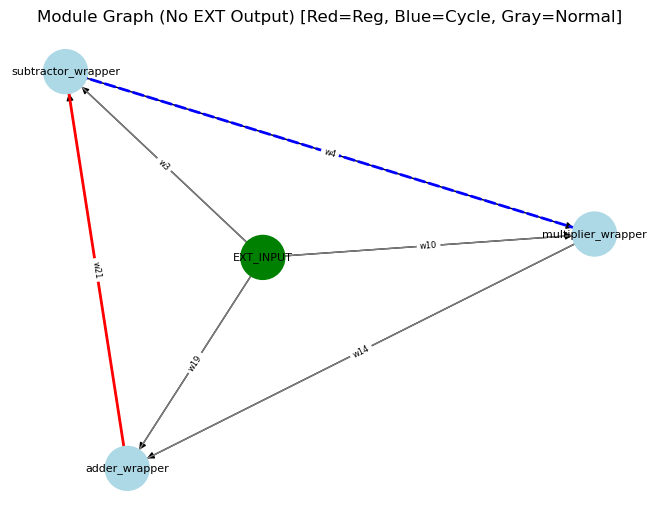

In [205]:
test_fuzz.visualize_graph_no_ext_out()

In [54]:
test_fuzz.module_tree

{'subtractor_wrapper': {'depth': 0,
  'tree': 0,
  'children': ['multiplier_wrapper', 'adder_wrapper'],
  'parents': [],
  'loops': []},
 'multiplier_wrapper': {'depth': 1,
  'tree': 0,
  'children': ['adder_wrapper'],
  'parents': ['subtractor_wrapper'],
  'loops': []},
 'adder_wrapper': {'depth': 2,
  'tree': 0,
  'children': [],
  'parents': ['multiplier_wrapper', 'subtractor_wrapper'],
  'loops': []}}

In [17]:
test_fuzz.all_wires

{7: Wire(id=7, in='input', out=['multiplier_wrapper_input_0'], reg=False),
 8: Wire(id=8, in='input', out=['multiplier_wrapper_input_1'], reg=False),
 9: Wire(id=9, in='input', out=['multiplier_wrapper_input_2'], reg=False),
 16: Wire(id=16, in='input', out=['adder_wrapper_input_0'], reg=False),
 18: Wire(id=18, in='input', out=['adder_wrapper_input_2'], reg=False),
 4: Wire(id=4, in='subtractor_wrapper_output_0', out=['output'], reg=False),
 5: Wire(id=5, in='subtractor_wrapper_output_1', out=['output'], reg=False),
 6: Wire(id=6, in='subtractor_wrapper_output_2', out=['output'], reg=False),
 11: Wire(id=11, in='multiplier_wrapper_output_0', out=['output'], reg=False),
 12: Wire(id=12, in='multiplier_wrapper_output_1', out=['output', 'subtractor_wrapper_input_0'], reg=False),
 13: Wire(id=13, in='multiplier_wrapper_output_2', out=['output', 'subtractor_wrapper_input_2', 'adder_wrapper_input_1'], reg=False),
 14: Wire(id=14, in='multiplier_wrapper_output_3', out=['output', 'adder_wrapp

In [140]:
test_fuzz.mod_IO

{'subtractor_wrapper': {'inputs': {11, 21}, 'outputs': {4, 5, 6}},
 'multiplier_wrapper': {'inputs': {7, 8, 9, 22},
  'outputs': {11, 12, 13, 14, 15}},
 'adder_wrapper': {'inputs': {13, 14, 15, 16}, 'outputs': {20, 21, 22}}}

In [330]:
test_fuzz.loops

{'loop_0': ['multiplier_wrapper', 'adder_wrapper', 'multiplier_wrapper'],
 'loop_1': ['multiplier_wrapper', 'subtractor_wrapper', 'multiplier_wrapper']}

In [13]:
verilog = test_fuzz.generate_top_module()

StopIteration: 

In [227]:
print(verilog)

// Auto-generated Top Module for flattened IO
`include "adder_wrapper.sv"
`include "multiplier_wrapper.sv"
`include "subtractor_wrapper.sv"

module top (
    input  wire clk,
    input  wire [9:0] in_flat,
    output wire [10:0] out_flat
);

// Per-module I/O buses
wire [3:0] adder_wrapper_in_flat;
wire [2:0] adder_wrapper_out_flat;
wire [3:0] multiplier_wrapper_in_flat;
wire [4:0] multiplier_wrapper_out_flat;
wire [3:0] subtractor_wrapper_in_flat;
wire [2:0] subtractor_wrapper_out_flat;

// Registered output shadows for looped modules
reg [2:0] adder_wrapper_out_reg;
always @(posedge clk) adder_wrapper_out_reg <= adder_wrapper_out_flat;

// External inputs to module inputs
assign subtractor_wrapper_in_flat[0] = in_flat[0];
assign subtractor_wrapper_in_flat[1] = in_flat[1];
assign subtractor_wrapper_in_flat[2] = in_flat[2];
assign subtractor_wrapper_in_flat[3] = in_flat[3];
assign multiplier_wrapper_in_flat[0] = in_flat[4];
assign multiplier_wrapper_in_flat[1] = in_flat[5];
assign mult